# **Trabalho 1. Disciplina: Aprendizado de Máquina**
#### **Pós-graduação em Ciência da Computação. DCC - UFMG**
#### **Aluno:** Gustavo Henrique Pereira Godinho
______________________________________________________

Importando ao ambiente os módulos necessários para a execução dos algoritmos:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Realizando a leitura dos dados através do módulo *pandas*. O conjunto de dados possui cerca de 5200 observações de candidatos a exoplanetas observados pela sonda *Kepler* da NASA. Como a coluna *kepoi_name* apenas identifica o exoplaneta, usarei ela como index do conjunto de dados.

In [2]:
koi_data = pd.read_csv('https://raw.githubusercontent.com/gustavohpgodinho/ml_trabalho_1/main/koi_data.csv').set_index('kepoi_name')
koi_data.head()

,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sdec,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
kepoi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,89.66,793.0,93.59,24.810,5.13585,28.47082,35.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.002,19.46229,48.14191,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,89.57,443.0,9.11,77.900,7.02767,20.10951,25.8,5455.0,4.467,0.14,0.927,0.919,15.347,15.890,15.270,15.114,15.006,14.082,13.751,13.648,0.003,19.46226,48.14199,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,67.09,1395.0,891.96,3.278,39.06655,541.89510,505.6,5805.0,4.564,-0.52,0.791,0.836,15.597,16.100,15.554,15.382,15.266,14.326,13.911,13.809,0.000,19.03564,48.28521,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,85.41,1406.0,926.16,8.750,4.74994,33.19190,40.9,6031.0,4.438,0.07,1.046,1.095,15.509,16.015,15.468,15.292,15.241,14.366,14.064,13.952,0.733,19.25033,48.22626,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,60.92,1342.0,767.22,2.400,10.96468,46.15308,47.7,6227.0,3.986,0.00,1.958,1.358,12.660,12.999,12.609,12.515,12.480,11.659,11.415,11.396,0.000,19.92395,42.15826,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


A tabela abaixo mostra que cerca de 40% das observações contidas no conjunto de dados são exoplanetas de fato, os 60% restantes são falsos positivos.

In [3]:
df_tabela = pd.DataFrame(koi_data['koi_disposition'].value_counts())
df_tabela['prop'] = round(df_tabela['koi_disposition']/sum(df_tabela['koi_disposition']), ndigits = 4)
df_tabela


,koi_disposition,prop
FALSE POSITIVE,3098,0.5955
CONFIRMED,2104,0.4045


### **Implementação**

Eu usarei os algoritmos implementados no módulo *sklearn* usando a estrutura de *Pipelines* quando necessário. Essa estrutura permite deixar o código mais organizado e orientado a objetos. Quando necessário eu usarei a padronização das covariáveis, isto é, deixarei todas na mesma escala, com média 0 e variância 1, eu preferi usar essa padronização porque eu acho ela mais interpretativa aos dados e facilita os cálculos dos algoritmos. Eu testei fazer isso nos algoritmos de Árvore de Decisão, Floresta Aleatória e Gradient Tree Boosting, no entanto o resultado não ficou melhor que não padronizando as variáveis e assim preferi não padronizar porque fica mais fácil interpretar esses classificadores.

Outra característica que eu preferi assumir nesse trabalho foi usar o argumento *shuffle* igual a verdadeiro na validação cruzada estratificada. Isso porque não ficou claro se o valor padrão desse argumento não embaralha os dados na validação cruzada.

## **Classificador Naive Bayes**

O classificador Naive Bayes será usado como o *baseline* desse experimento. Esse classificador é baseado no Teorema de mesmo nome calculado primeiramente pelo matemático inglês Thomas Bayes. Ele recebe o adjetivo de *naive (ingênuo em português)* por fazer a suposição de que a distribuição condicional de que uma covariável (*feature*) presente no conjunto de dados dado a variável-alvo é independente da distribuição condicional das outras covariáveis do conjunto de dados também dado a variável-alvo. Essa suposição dificilmente é válida em problemas reais, pois covariáveis costumam se correlacionar, ainda assim esse classificador fornece boas estimativas e é muito simples.

Para o classificador Naive Bayes eu padronizarei as *features*, deixando-as com média 0 e variância 1 e após isso aplicarei o Naive Bayes Gaussiano, pelo que vimos na aula e pelo que li na documentação essa é a variação do Naive Bayes é o que mais se enquadra com as covariáveis contínuas que temos. O Naive Bayes Gaussiano tem apenas um hiperparâmetro que é a suavização da variância, esse hiperparâmetro é usado segundo a documentação do algoritmo para dar estabilidade no cálculo das probabilidades. Como o Naive Bayes está sendo usado apenas como *baseline* nesse estudo, eu usarei apenas o valor padrão para esse hiperparâmetro.

In [4]:
# pipeline para padronização dos dados e depois disso a criação do classificador Naive Bayes Gaussiano
classificador_naive_bayes = Pipeline(
    steps = [('padronizacao covariaveis', StandardScaler()),
             ('naive_bayes', GaussianNB())])

# definição do hiperparametro usado nesse classificador, nesse caso estou definindo apenas como o valor default.
hiperparametro_naive_bayes = {'naive_bayes__var_smoothing': [1e-9]}

# criação do grid para NESSE CASO ajustar o algoritmo Naive Bayes com 5 folds de validação cruzada. 
# Além disso, estou pedindo para o grid ser executado em paralelo, usar a métrica acurácia e retornar 
# também a acurácia nos conjuntos de treinamento usado em cada fold.
grid_naive_bayes = GridSearchCV(estimator = classificador_naive_bayes, 
                                param_grid = hiperparametro_naive_bayes, 
                                cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1313),
                                n_jobs = -1, scoring = 'accuracy', 
                                return_train_score = True)

# ajuste do grid com o conjunto de dados do estudo
grid_naive_bayes.fit(X = koi_data.drop(['koi_disposition'], axis = 1), 
                     y = koi_data['koi_disposition'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1313, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('padronizacao covariaveis',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('naive_bayes',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'naive_bayes__var_smoothing': [1e-09]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [6]:
print("Acurácia média nos folds de teste do modelo Naive Bayes: %.4f" % grid_naive_bayes.cv_results_['mean_test_score'])


Acurácia média nos folds de teste do modelo Naive Bayes: 0.9170


A acurácia em cada um dos folds de teste na validação cruzada foram:

In [7]:
splits = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
pd.DataFrame(grid_naive_bayes.cv_results_)[splits]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.920269,0.914505,0.914423,0.911538,0.924038


# **Classificador Árvore de Decisão**

O próximo algoritmo a ser feito é a *Decision Tree*, em português Árvore de Decisão. Aqui devemos variar a profundidade máxima da árvore, quanto mais profunda permitimos que a árvore seja mais divisões o algoritmo vai procurar fazer, isto é, mais nós de divisão a árvore terá. Um número baixo do hiperparâmetro *max_depth* poderá deixar o classificador aquém da capacidade dos dados levando ao *underfitting* e um número alto desse hiperparâmetro poderá deixar o classificador além da capacidade dos dados levando ao *overfitting*. O critério de divisão dos nós que usarei é a entropia que foi o que aprendemos na aula, a divisão acontecerá no ponto da variável que levará a menor entropia e consequentemente ao maior ganho de informação.

In [9]:
# criação do classificador a partir do algoritmo árvore de decisão. Aqui não é necessário normalizar os dados 
# porque isso não faz diferença para a árvore.
classificador_arvore_decisao = DecisionTreeClassifier(criterion = 'entropy')

# definindo os valores possiveis para o hiperparametro profundidade da árvore
hiperparametro_arvore_decisao = {'max_depth': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]}

# criando o grid que irá testar todos esses possíveis valores de profundidade e 
# retornar o melhor a partir da avaliação dos resultados através de validação cruzada.
grid_arvore_decisao = GridSearchCV(estimator = classificador_arvore_decisao, 
                                   param_grid = hiperparametro_arvore_decisao, 
                                   cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1313), 
                                   n_jobs = -1, scoring = 'accuracy', return_train_score = True)

# ajustando o grid feito para árvore de decisão aos nossos dados:
grid_arvore_decisao.fit(X = koi_data.drop(['koi_disposition'], axis = 1),
                        y = koi_data['koi_disposition'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1313, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
     

In [10]:
print("A Árvore de Decisão com profundidade máxima de %d é a que obteve melhor acurácia \
média nos folds de teste durante ajuste. \nO valor médio dessa acurácia foi de: %.4f" 
      % (grid_arvore_decisao.best_params_['max_depth'], grid_arvore_decisao.best_score_))

A Árvore de Decisão com profundidade máxima de 20 é a que obteve melhor acurácia média nos folds de teste durante ajuste. 
O valor médio dessa acurácia foi de: 0.9504


A acurácia em cada um dos folds de teste na validação cruzada foram:

In [11]:
splits = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
max_depth = str(grid_arvore_decisao.best_params_['max_depth'])
pd.DataFrame(grid_arvore_decisao.cv_results_).query("param_max_depth == " + max_depth)[splits]


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
6,0.951009,0.940442,0.946154,0.953846,0.960577


Resultados da acurácia média da árvore variando a profundidade máxima no fold de teste e nos folds de treino.

In [12]:
pd.DataFrame(grid_arvore_decisao.cv_results_)[['param_max_depth','mean_test_score','mean_train_score']]

,param_max_depth,mean_test_score,mean_train_score
0,1,0.718375,0.719771
1,2,0.903306,0.905373
2,3,0.933871,0.937092
3,4,0.945598,0.950884
4,5,0.946174,0.958141
5,10,0.949442,0.994425
6,20,0.950405,1.000000
7,30,0.949827,1.000000
8,40,0.949443,1.000000
9,50,0.949443,1.000000


Fazendo o gráfico do valor da acurácia média obtida por profundidade máxima da árvore de decisão:

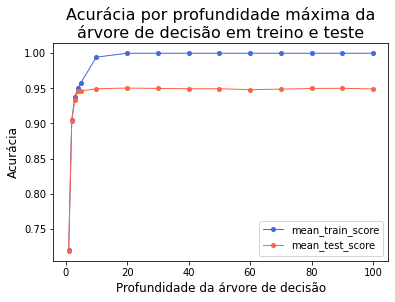

In [13]:
df_arvore_decisao = pd.DataFrame(grid_arvore_decisao.cv_results_)[['param_max_depth','mean_test_score','mean_train_score']]
plt.plot('param_max_depth', 'mean_train_score', data = df_arvore_decisao, 
         marker = 'o', markerfacecolor = 'royalblue', markersize = 4, 
         color = 'royalblue', linewidth = 1)
plt.plot('param_max_depth', 'mean_test_score', data = df_arvore_decisao, 
         marker = 'o', markerfacecolor = 'tomato', markersize = 4, 
         color = 'tomato', linewidth = 1)
plt.legend()
plt.title('Acurácia por profundidade máxima da\nárvore de decisão em treino e teste', fontsize = 16)
plt.xlabel('Profundidade da árvore de decisão', fontsize = 12)
plt.ylabel('Acurácia', fontsize = 12)
axes = plt.gca()
plt.show()

# **Classificador KNN**

O próximo algoritmo a ser testado é o KNN, esse é um dos algoritmos mais fáceis de ser explicado, já que a estimativa para um ponto qualquer é dado pela moda dos k pontos vizinhos mais próximos a ele. Nesse algoritmo eu padronizarei as covariáveis, para deixá-las na mesma escala. Isso é importante para esse algoritmo porque se não for feito pode distorcer o que é perto ou não por conta da variância de determinada variável. O hiperparâmetro a ser testado é o número de vizinhos a ser considerado na estimativa da classe dos pontos. Vou variar esse valor desde k muito pequenos até valores enormes. A princípio uma parte contra-intuitiva desse algoritmo é que poucos vizinhos levam a possível *overfitting* e estimativas considerando muitos vizinhos podem lever a *underfitting*, ou seja, valores pequenos de k devem levar ao *overfitting* já que pontos muito próximos podem ter estimativas diferentes, o chamado erro de variância. Já valores muito grandes de k podem levar a *underfitting*.

In [14]:
# APROXIMADAMENTE 2 MINUTOS E 30 SEGUNDOS PARA RODAR
# criação do classificador a partir do algoritmo knn.
classificador_knn = Pipeline(
    steps = [('padronizacao covariaveis', StandardScaler()),
             ('knn', KNeighborsClassifier())])

# definindo os valores possíveis para o hiperparâmetro k que representa o número de vizinhos a ser considerado.
hiperparametro_knn = {'knn__n_neighbors': list(range(1, 10)) + list(range(10, 101, 10)) + list(range(100, 2001, 400))}

# criando o grid que irá testar todos esses possíveis valores de vizinhos e retornar
# o melhor a partir da avaliação dos resultados através de validação cruzada.
grid_knn = GridSearchCV(estimator = classificador_knn, param_grid = hiperparametro_knn, 
                        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1313), 
                        n_jobs = -1, scoring = 'accuracy', return_train_score = True)

# ajustando o algoritmo aos dados do nosso estudo
grid_knn.fit(X = koi_data.drop(['koi_disposition'], axis = 1), 
             y = koi_data['koi_disposition'])


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1313, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('padronizacao covariaveis',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                    

In [15]:
print("O KNN com %d vizinhos é o que obteve melhor acurácia \
média nos folds de teste durante ajuste. \nO valor médio dessa acurácia foi de: %.4f" 
      % (grid_knn.best_params_['knn__n_neighbors'], grid_knn.best_score_))

O KNN com 3 vizinhos é o que obteve melhor acurácia média nos folds de teste durante ajuste. 
O valor médio dessa acurácia foi de: 0.8929


Resultados da acurácia média do KNN variando o número de vizinhos no fold de teste e nos folds de treino.

In [16]:
pd.DataFrame(grid_knn.cv_results_)[['param_knn__n_neighbors','mean_test_score','mean_train_score']]

,param_knn__n_neighbors,mean_test_score,mean_train_score
0,1,0.888124,1.000000
1,2,0.864861,0.914648
2,3,0.892928,0.934641
3,4,0.877741,0.906719
4,5,0.892158,0.919502
5,6,0.877547,0.901721
6,7,0.890812,0.911140
7,8,0.880047,0.898308
8,9,0.889081,0.904700
9,10,0.879662,0.892733


Fazendo o gráfico do valor da acurácia média obtida por número de vizinhos k considerados no algoritmo KNN, note como a acurácia média no fold de teste e também no fold de treino vai caindo a medida que o número de vizinhos cresce:

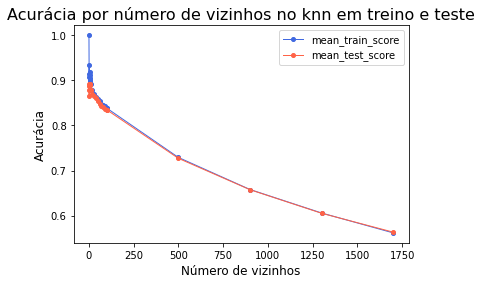

In [17]:
df_knn = pd.DataFrame(grid_knn.cv_results_)[['param_knn__n_neighbors','mean_test_score','mean_train_score']]
plt.plot('param_knn__n_neighbors', 'mean_train_score', data = df_knn, marker = 'o', 
         markerfacecolor = 'royalblue', markersize = 4, color = 'royalblue', linewidth = 1)
plt.plot('param_knn__n_neighbors', 'mean_test_score', data = df_knn, marker = 'o', 
         markerfacecolor = 'tomato', markersize = 4, color = 'tomato', linewidth = 1)
plt.legend()
plt.title('Acurácia por número de vizinhos no knn em treino e teste', fontsize = 16)
plt.xlabel('Número de vizinhos', fontsize = 12)
plt.ylabel('Acurácia', fontsize = 12)
axes = plt.gca()
#axes.set_ylim([0,1.05])
plt.show()

A acurácia em cada um dos folds de teste na validação cruzada foram:

In [18]:
splits = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
num_vizinhos = str(grid_knn.best_params_['knn__n_neighbors'])
pd.DataFrame(grid_knn.cv_results_).query("param_knn__n_neighbors ==" + num_vizinhos)[splits]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
2,0.891451,0.880884,0.894231,0.893269,0.904808


# **Classificador SVM**

O SVM foi um dos algoritmos que mais estudamos durante a disciplina até aqui. Esse é um classificador linear e aqui o objetivo é variar o hiperparâmetro kernel para verificar qual deles gera o melhor resultado no conjunto de teste por validação cruzada. O hiperparâmetro kernel quando não é o linear faz a transformação levando os dados para um novo espaço de dimensão mais alta e tentando fazer a separação linear por lá. Testaremos os 4 hiperparâmetros pedidos no trabalho: linear, polinomial, radial e sigmoid. Além disso, os outros hiperparâmetros como o C e o grau do polinômio para o kernel polinomial serão deixados no valor padrão (C = 1, grau polinômio = 3). Eu padronizei os dados colocando-os com média 0 e variância 1, pois percebi que isso diminui o tempo computacional. Assim como todos os outros algoritmos está sendo usado a validação cruzada com 5 folds.

In [20]:
# APROXIMADAMENTE 30 SEGUNDOS PARA EXECUTAR
# criação do classificador a partir do algoritmo svm.
classificador_svm = Pipeline(
    steps = [('padronizacao covariaveis', StandardScaler()),
             ('svm', SVC(probability = True))])

# definindo os valores possíveis para o hiperparâmetro kernel.
hiperparametros_svm = {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

# criando o grid que irá testar todos esses possíveis funções de kernel e retornar
# o melhor a partir da avaliação dos resultados através de validação cruzada.
grid_svm = GridSearchCV(estimator = classificador_svm, param_grid = hiperparametros_svm, 
                        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1313),
                        n_jobs = -1, scoring = 'accuracy', return_train_score = True)

# ajustando o algoritmo aos dados do nosso estudo
grid_svm.fit(X = koi_data.drop(['koi_disposition'], axis = 1), y = koi_data['koi_disposition'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1313, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('padronizacao covariaveis',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svm',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=True, random_state=None,
                        

In [21]:
print("O SVM com kernel %s é o que obteve melhor acurácia média nos folds de teste durante ajuste. \nO valor médio dessa acurácia foi de: %.4f" 
      % (grid_svm.best_params_['svm__kernel'], grid_svm.best_score_))

O SVM com kernel linear é o que obteve melhor acurácia média nos folds de teste durante ajuste. 
O valor médio dessa acurácia foi de: 0.9531


Resultados da acurácia média do SVM variando a função de kernel:

In [22]:
pd.DataFrame(grid_svm.cv_results_)[['param_svm__kernel', 'mean_test_score', 'mean_train_score']]


,param_svm__kernel,mean_test_score,mean_train_score
0,linear,0.953096,0.955017
1,poly,0.881010,0.890618
2,rbf,0.937524,0.943147
3,sigmoid,0.822954,0.823529


A acurácia em cada um dos folds de teste na validação cruzada foram:

In [23]:
splits = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
pd.DataFrame(grid_svm.cv_results_).query('param_svm__kernel == "linear"')[splits]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.960615,0.942363,0.952885,0.953846,0.955769


# **Classificador Floresta Aleatória**

O próximo algoritmo a ser testado nos dados é a *Random Forest*, em português Floresta Aleatória. Esse é um método *ensemble* pois combina várias árvores de decisão através de uma técnica chamada *bagging*. Isso significa que é feito um *bootstrap* nos dados de treino em cada Árvore de Decisão e para cada uma delas é gerada uma predição. A predição final para cada observação em problemas de classificação é dada pela moda das predições para aquela observação em cada árvore. O hiperparâmetro a ser variado aqui é o número de árvores na floresta aleatória, chamado de *n_estimators* pelo sklearn. Um número pequeno de árvores, significa que a floresta será pequena e poucas árvores serão construídas para gerar as estimativas. Já se um número grande de árvores é solicitado, significa que a floresta será grande e muitas árvores serão construídas para gerar as estimativas. O critério para divisão dos nós que será usado é a entropia, que é o mesmo que usamos na Árvore de Decisão e o mesmo que usamos durante a aula. Assim como para o classificador da Árvore de Decisão, aqui não será padronizada as covariáveis porque não faz diferença para esse classificador. A profundidade de cada uma das árvores construídas será deixada como o valor padrão que é *None*, ou seja, as árvores dividiram os dados até que todas as folhas sejam puras ou até que todas as folhas tenham somente um número mínimo de observações, que por padrão da implementação do sklearn é 2.

In [24]:
# APROXIMADAMENTE 2 MINUTOS PARA EXECUTAR
# criação do classificador a partir do algoritmo random forest.
classificador_floresta_aleatoria = RandomForestClassifier(criterion = 'entropy')

# definindo os valores possíveis para o hiperparâmetro número de árvores na floresta.
hiperparametro_floresta_aleatoria = {'n_estimators': [1, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]}

# criando o grid que irá testar todos esses números de árvores da floresta e retornar
# o melhor a partir da avaliação dos resultados através de validação cruzada.
grid_floresta_aleatoria = GridSearchCV(estimator = classificador_floresta_aleatoria, 
                                       param_grid = hiperparametro_floresta_aleatoria, 
                                       cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1313), 
                                       n_jobs = -1, scoring = 'accuracy', return_train_score = True)

# ajustando o algoritmo da floresta aleatória aos dados do nosso estudo
grid_floresta_aleatoria.fit(X = koi_data.drop(['koi_disposition'], axis = 1), 
                            y = koi_data['koi_disposition'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1313, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs

In [25]:
print("A Floresta Aleatória com %d árvores é a que obteve melhor acurácia média nos folds de teste durante ajuste. \nO valor médio dessa acurácia foi de: %.4f" 
      % (grid_floresta_aleatoria.best_params_['n_estimators'], grid_floresta_aleatoria.best_score_))

A Floresta Aleatória com 400 árvores é a que obteve melhor acurácia média nos folds de teste durante ajuste. 
O valor médio dessa acurácia foi de: 0.9723


Resultados da acurácia média nos folds de teste durante ajuste da Floresta Aleatória variando o número de árvores na floresta:

In [26]:
pd.DataFrame(grid_floresta_aleatoria.cv_results_)[['param_n_estimators','mean_test_score','mean_train_score']]

,param_n_estimators,mean_test_score,mean_train_score
0,1,0.939640,0.974962
1,5,0.960208,0.995675
2,10,0.969629,0.997933
3,20,0.970975,0.999135
4,30,0.971550,0.999712
5,40,0.969629,0.999808
6,50,0.970782,0.999856
7,100,0.970205,0.999952
8,200,0.971551,1.000000
9,300,0.971167,1.000000


A acurácia em cada um dos folds de teste da validação cruzada para a floresta com o melhor número de árvores testado é:

In [27]:
splits = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
num_arvores = str(grid_floresta_aleatoria.best_params_['n_estimators'])
pd.DataFrame(grid_floresta_aleatoria.cv_results_).query('param_n_estimators ==' + num_arvores)[splits]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
10,0.975024,0.961575,0.974038,0.971154,0.979808


Fazendo o gráfico do valor da acurácia média obtida por número de árvores consideradas no algoritmo Floresta Aleatória, a acurácia média em teste é muito alta para valores pequenos de número de árvores, como 5 até para os maiores valores testados para esse hiperparâmetro.

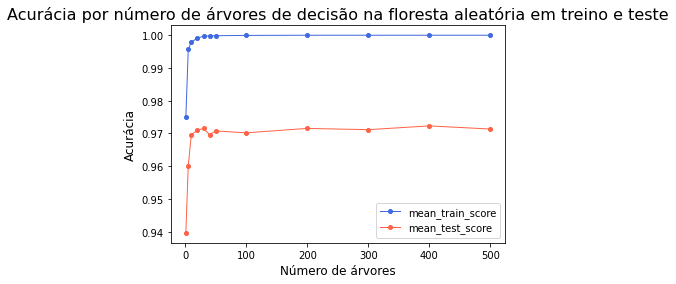

In [28]:
df_floresta_aleatoria = pd.DataFrame(grid_floresta_aleatoria.cv_results_)[['param_n_estimators','mean_test_score','mean_train_score']]
plt.plot('param_n_estimators', 'mean_train_score', data = df_floresta_aleatoria, marker = 'o', 
         markerfacecolor = 'royalblue', markersize = 4, color = 'royalblue', linewidth = 1)
plt.plot('param_n_estimators', 'mean_test_score', data = df_floresta_aleatoria, marker = 'o', 
         markerfacecolor = 'tomato', markersize = 4, color = 'tomato', linewidth = 1)
plt.legend()
plt.title('Acurácia por número de árvores de decisão na floresta aleatória em treino e teste', fontsize = 16)
plt.xlabel('Número de árvores', fontsize = 12)
plt.ylabel('Acurácia', fontsize = 12)
axes = plt.gca()
#axes.set_ylim([0,1.05])
plt.show()

# **Classificador Gradient Tree Boosting**

O último algoritmo a ser testado nos dados é a Gradiente Tree Boosting. Esse é um algoritmo que também usa de um método chamado ensemble pois ele combina as predições dadas por várias Árvores de Decisão através de uma técnica chamada boosting. Isso significa que várias Árvores de Decisão são construídas em sequência, onde a árvore sucessora tenta corrigir os erros de classificação da árvore anterior a ela. A predição final para cada observação em problemas de classificação é dada pela moda das predições para aquela observação em cada árvore do boosting. O hiperparâmetro a ser variado aqui é o número de iterações que serão feitas, chamado de *n_estimators* pelo sklearn. Um número pequeno de iterações, significa que serão usadas poucas árvores de decisão para corrigir uma a outra. Se um número grande de iteraçoes significa que serão usadas muitas Árvores de Decisão para corrigir uma a outra. A profundidade de cada uma dessas árvores será deixada no valor padrão do sklearn que é 3 e o número de covariáveis usadas em cada uma das árvores também será deixada no valor padrão que é todas as covariáveis.


In [29]:
# APROXIMADAMENTE 2 MINUTOS PARA EXECUTAR
# criação do classificador a partir do algoritmo gradient tree boosting.
classificador_gtb = GradientBoostingClassifier()

# definindo os valores possíveis para o hiperparâmetro número de iterações do algoritmo.
hiperparametro_gtb = {'n_estimators': [1, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]}

# criando o grid que irá testar todos esses números de árvores do Gradient Tree Boosting e retornar
# o melhor a partir da avaliação dos resultados através de validação cruzada.
grid_gtb = GridSearchCV(estimator = classificador_floresta_aleatoria, 
                        param_grid = hiperparametro_gtb, 
                        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1313),
                        n_jobs = -1, scoring = 'accuracy', return_train_score = True)

# ajustando o algoritmo da floresta aleatória aos dados do nosso estudo
grid_gtb.fit(X = koi_data.drop(['koi_disposition'], axis = 1), 
             y = koi_data['koi_disposition'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1313, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs

In [30]:
print("O Gradient Tree Boosting com %d iterações é o que obteve melhor acurácia média nos folds de teste durante ajuste. \nO valor médio dessa acurácia foi de: %.4f" 
      % (grid_gtb.best_params_['n_estimators'], grid_gtb.best_score_))

O Gradient Tree Boosting com 400 iterações é o que obteve melhor acurácia média nos folds de teste durante ajuste. 
O valor médio dessa acurácia foi de: 0.9723


Resultados da acurácia média nos folds de teste da validação cruzada do Gradient Tree Boosting variando o número de iterações do algoritmo:

In [31]:
pd.DataFrame(grid_gtb.cv_results_)[['param_n_estimators','mean_test_score','mean_train_score']]

,param_n_estimators,mean_test_score,mean_train_score
0,1,0.935029,0.975490
1,5,0.962516,0.995627
2,10,0.963862,0.997405
3,20,0.970205,0.999231
4,30,0.969628,0.999808
5,40,0.968860,0.999760
6,50,0.968860,0.999952
7,100,0.971743,1.000000
8,200,0.970590,1.000000
9,300,0.970975,1.000000


A acurácia em cada um dos folds de teste da validação cruzada para o Gradient Tree Boosting com o melhor número de iterações testado é:

In [32]:
splits = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']
num_estimators = str(grid_gtb.best_params_['n_estimators'])
pd.DataFrame(grid_gtb.cv_results_).query('param_n_estimators == ' + num_estimators)[splits]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
10,0.973103,0.962536,0.972115,0.972115,0.981731


Fazendo o gráfico do valor da acurácia média obtida por número de iterações consideradas no algoritmo Gradient Tree Boosting.

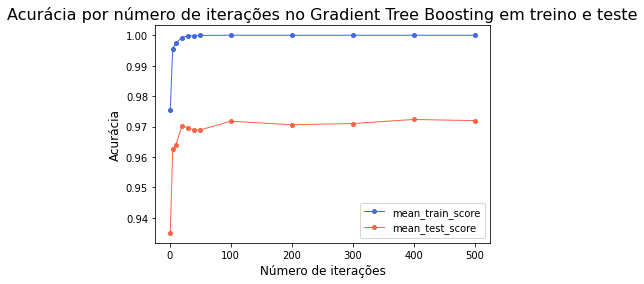

In [33]:
df_gtb = pd.DataFrame(grid_gtb.cv_results_)[['param_n_estimators','mean_test_score','mean_train_score']]
plt.plot('param_n_estimators', 'mean_train_score', data = df_gtb, marker = 'o', 
         markerfacecolor = 'royalblue', markersize = 4, color = 'royalblue', linewidth = 1)
plt.plot('param_n_estimators', 'mean_test_score', data = df_gtb, marker = 'o', 
         markerfacecolor = 'tomato', markersize = 4, color = 'tomato', linewidth = 1)
plt.legend()
plt.title('Acurácia por número de iterações no Gradient Tree Boosting em treino e teste', fontsize = 16)
plt.xlabel('Número de iterações', fontsize = 12)
plt.ylabel('Acurácia', fontsize = 12)
axes = plt.gca()
#axes.set_ylim([0,1.05])
plt.show()

# **Comparação dos classificadores**

Por fim vamos comparar os classificadores gerados através das métricas de precisão, também conhecida como sensibilidade e Recall que é a taxa das estimativas certas do classificador entre os casos positivos do conjunto de dados. Além disso também usaremos a curva ROC que é usada para encontrar o treshold (patamar de corte) entre uma categoria e outra, mas aqui o foco será verificar a área deixada por ela sob a curva gerada pelos classificadores, quanto maior melhor. Os classificadores analisados são aqueles construídos anteriormente com os melhores valores de hiperparâmetro verificados na validação cruzada.

______________________________________________________________

Naive Bayes
Esse classificador tem acurácia esperada em novos dados de aproximadamente 0.9170.   
Isso significa que em mais objetos candidatos a exoplanetas, esse classificador identificará a disposição exatas dos objetos em 91.70% dos casos.
A precisão do classificador nos dados de treino foi de 0.8425, ou seja, das observações do treino que esse classificador estimou como exoplanetas, 84.25% realmente eram.
O recall do classificador nos dados de treino foi de 0.9734, ou seja, 97.34% dos exoplanetas dos dados de treino foram classificados corretamente.


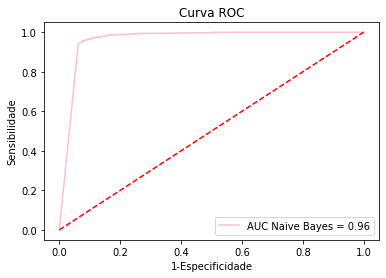

______________________________________________________________

Árvore de Decisão
Esse classificador tem acurácia esperada em novos dados de aproximadamente 0.9504.   
Isso significa que em mais objetos candidatos a exoplanetas, esse classificador identificará a disposição exatas dos objetos em 95.04% dos casos.
A precisão do classificador nos dados de treino foi de 1.0000, ou seja, das observações do treino que esse classificador estimou como exoplanetas, 100.00% realmente eram.
O recall do classificador nos dados de treino foi de 1.0000, ou seja, 100.00% dos exoplanetas dos dados de treino foram classificados corretamente.


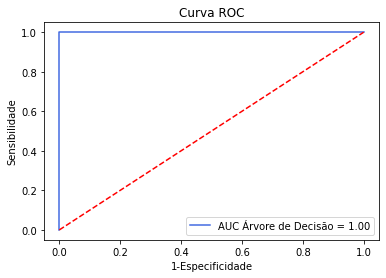

______________________________________________________________

KNN
Esse classificador tem acurácia esperada em novos dados de aproximadamente 0.8929.   
Isso significa que em mais objetos candidatos a exoplanetas, esse classificador identificará a disposição exatas dos objetos em 89.29% dos casos.
A precisão do classificador nos dados de treino foi de 0.8797, ou seja, das observações do treino que esse classificador estimou como exoplanetas, 87.97% realmente eram.
O recall do classificador nos dados de treino foi de 0.9767, ou seja, 97.67% dos exoplanetas dos dados de treino foram classificados corretamente.


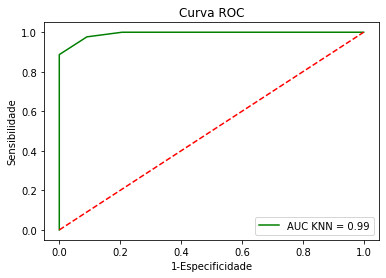

______________________________________________________________

SVM
Esse classificador tem acurácia esperada em novos dados de aproximadamente 0.9531.   
Isso significa que em mais objetos candidatos a exoplanetas, esse classificador identificará a disposição exatas dos objetos em 95.31% dos casos.
A precisão do classificador nos dados de treino foi de 0.9291, ou seja, das observações do treino que esse classificador estimou como exoplanetas, 92.91% realmente eram.
O recall do classificador nos dados de treino foi de 0.9648, ou seja, 96.48% dos exoplanetas dos dados de treino foram classificados corretamente.


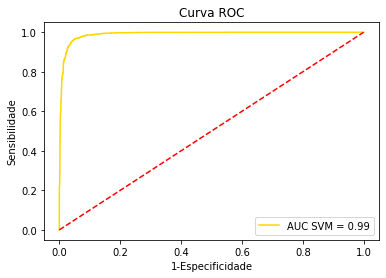

______________________________________________________________

Floresta Aleatória
Esse classificador tem acurácia esperada em novos dados de aproximadamente 0.9723.   
Isso significa que em mais objetos candidatos a exoplanetas, esse classificador identificará a disposição exatas dos objetos em 97.23% dos casos.
A precisão do classificador nos dados de treino foi de 1.0000, ou seja, das observações do treino que esse classificador estimou como exoplanetas, 100.00% realmente eram.
O recall do classificador nos dados de treino foi de 1.0000, ou seja, 100.00% dos exoplanetas dos dados de treino foram classificados corretamente.


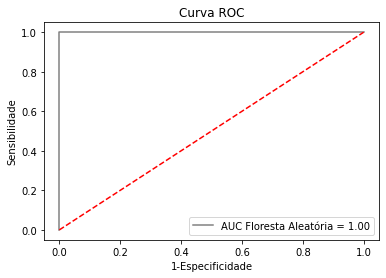

______________________________________________________________

Gradient Tree Boosting
Esse classificador tem acurácia esperada em novos dados de aproximadamente 0.9723.   
Isso significa que em mais objetos candidatos a exoplanetas, esse classificador identificará a disposição exatas dos objetos em 97.23% dos casos.
A precisão do classificador nos dados de treino foi de 1.0000, ou seja, das observações do treino que esse classificador estimou como exoplanetas, 100.00% realmente eram.
O recall do classificador nos dados de treino foi de 1.0000, ou seja, 100.00% dos exoplanetas dos dados de treino foram classificados corretamente.


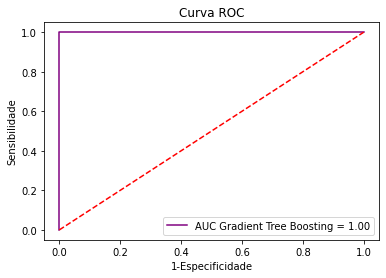

In [39]:
nome_classificador = ['Naive Bayes', 'Árvore de Decisão', 'KNN', 'SVM', 'Floresta Aleatória', 'Gradient Tree Boosting']
classificador = [grid_naive_bayes, grid_arvore_decisao, grid_knn, grid_svm, grid_floresta_aleatoria, grid_gtb]
cores_linhas = ['pink', 'royalblue', 'green', 'gold', 'gray', 'purple']

for i in range(len(classificador)):
  precisao = metrics.precision_score(y_true = koi_data['koi_disposition'], 
                                     y_pred = classificador[i].predict(koi_data.drop(['koi_disposition'], axis = 1)), 
                                     pos_label = 'CONFIRMED')               

  recall = metrics.recall_score(y_true = koi_data['koi_disposition'], 
                                y_pred = classificador[i].predict(koi_data.drop(['koi_disposition'], axis = 1)), 
                                pos_label = 'CONFIRMED')
  
  print('______________________________________________________________\n')
  print("%s\nEsse classificador tem acurácia esperada em novos dados de aproximadamente %.4f. \
  \nIsso significa que em mais objetos candidatos a exoplanetas, esse classificador identificará a disposição exatas dos objetos em %.2f%% dos casos." 
        %(nome_classificador[i], classificador[i].best_score_, 100*classificador[i].best_score_))
  print("A precisão do classificador nos dados de treino foi de %.4f, ou seja, das observações do treino que esse classificador estimou como exoplanetas, %.2f%% realmente eram." 
        %(precisao, 100*precisao))
  print("O recall do classificador nos dados de treino foi de %.4f, ou seja, %.2f%% dos exoplanetas dos dados de treino foram classificados corretamente." 
        %(recall, 100*recall))

  fpr, tpr, threshold = metrics.roc_curve(y_true = koi_data['koi_disposition'], 
                                          y_score = classificador[i].predict_proba(koi_data.drop(['koi_disposition'], axis = 1))[:,0], 
                                          pos_label = 'CONFIRMED')
  roc_auc = metrics.auc(fpr, tpr)
  plt.title('Curva ROC')
  plt.plot(fpr, tpr, 'b', label = 'AUC %s = %0.2f' % (nome_classificador[i], roc_auc), color = cores_linhas[i])
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1], 'r--')
  plt.xlim([-0.05, 1.05]) # deixando uma folga nos eixos para melhor visualização dos gráficos
  plt.ylim([-0.05, 1.05]) # deixando uma folga nos eixos para melhor visualização dos gráficos
  plt.ylabel('Sensibilidade')
  plt.xlabel('1-Especificidade')
  plt.show()




Abaixo há uma tabela resumindo os algoritmos testados e os hiperparâmetros que apresentaram melhor resultado no conjunto de dados, juntamente com a acurácia média nos folds de teste na validação cruzada.

In [41]:
pd.DataFrame({'classificador': ['Naive Bayes', 'Árvore de Decisão', 'KNN', 'SVM', 'Floresta Aleatória', 'Gradient Tree Boosting'], 
              'hiperparâmetro': [None, grid_arvore_decisao.best_params_, grid_knn.best_params_, grid_svm.best_params_, grid_floresta_aleatoria.best_params_, grid_gtb.best_params_],
              'acuracia_esperada': [grid_naive_bayes.best_score_, grid_arvore_decisao.best_score_, grid_knn.best_score_, grid_svm.best_score_, grid_floresta_aleatoria.best_score_, grid_gtb.best_score_]})


,classificador,hiperparâmetro,acuracia_esperada
0,Naive Bayes,None,0.916955
1,Árvore de Decisão,{'max_depth': 20},0.950405
2,KNN,{'knn__n_neighbors': 3},0.892928
3,SVM,{'svm__kernel': 'linear'},0.953096
4,Floresta Aleatória,{'n_estimators': 400},0.972320
5,Gradient Tree Boosting,{'n_estimators': 400},0.972320


# **Conclusões finais**

Aqui foi feito um trabalho para a disciplina de Aprendizado de Máquina, cujo o objetivo foi avaliar algoritmos de aprendizagem na classificação de exoplanetas. Foram feitos 6 classificadores: Naive Bayes, Árvore de Decisão, KNN, SVM, Floresta Aleatória e Gradient Tree Boosting, sendo o primeiro deles somente um caso base e os dois últimos métodos ensemble. Foi usada validação cruzada com 5 partições nos dados de treino, onde cada classificador foi treinado 5 vezes, sempre variando a partição de teste, ou seja, usando 4 das partições como dados de treino e a partição restante como dados de teste.

Como vimos em aula, a estimativa de erro dada pela validação cruzada (e consequentemente a estimativa de acertos) é uma boa aproximação do erro esperado. A partir disso, pode ser notado nesse trabalho que os métodos ensemble geraram estimativas superiores aos outros métodos. A árvore de decisão e o SVM com kernel linear também performaram muito bem e acredito eu que buscando melhores valores para outros hiperparâmetros, poderíamos chegar em resultados ainda melhores para esses classificadores. Os classificadores que tiveram taxas de erros estimadas mais altas foram o Naive Bayes e o KNN.